# Muon Tag and Probe

The following notebook demonstrates the muon TnP utility.

The steps are:
1. create the tag and probe tree (not shown here)
    - Data was created with [this config](https://github.com/KyeongPil-Lee/MuonAnalysis-TagAndProbe/blob/102X/test/zmumu/tp_from_aod_Data_106X_dataRun2_v20.py)
    - MC was created with [this config](https://github.com/KyeongPil-Lee/MuonAnalysis-TagAndProbe/blob/102X/test/zmumu/tp_from_aod_MC_102X_v15.py)
2. optionally convert the root trees to the parquet format
3. flatten the tree into 1D histograms
4. fit the histograms with the chosen functional/template form
5. extract the scalefactors and systematics.

This notebook will use Apache Spark to distribute the conversion step.
Eventually, the goal is to have Apache Spark also distribute the fitting step.
Currently this is done

### Before you begin

Connect to [swan.cern.ch](swan.cern.ch).

Make certain you have connected to the latest `python3` software stack with the `k8s` spark cluster.
If you have access to another cluster (e.g. `analytix`), you may connect to that instead.

Execute the following cells to download the necessary `jar` files for use with spark.
You only need to do this step if you are going to read root files.
If you read parquet files, there is no need for external `jar` files.

In [ ]:
# spark.jars.packages doesnt work with Spark 2.4 with kubernetes, use spark.jars and spark.driver.extraClassPath instead
!wget -N https://repo1.maven.org/maven2/edu/vanderbilt/accre/laurelin/1.0.0/laurelin-1.0.0.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-api/2.13.0/log4j-api-2.13.0.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-core/2.13.0/log4j-core-2.13.0.jar

Additionally, if you wish to run the fitting steps at the end, you will need to install `uproot`, `uproot_methods`, and `probfit`.

In [8]:
!pip install --user uproot
!pip install --user uproot_methods
!pip install --user probfit

### Begin the spark session

Click the 5-pointed star.
By default, only the `k8s` cluster is available to all users.

For `k8s`, you will need the options:
- `spark.dynamicAllocation.maxExecutors`: `100`
- `spark.driver.memory`: `6g`
- `spark.jars`: `laurelin-1.0.0.jar,log4j-api-2.13.0.jar,log4j-core-2.13.0.jar`
- `spark.kubernetes.container.image`: `gitlab-registry.cern.ch/db/spark-service/docker-registry/swan:laurelin`
- `spark.kubernetes.container.image.pullPolicy`: `Always`
- `spark.driver.extraClassPath`: `./laurelin-1.0.0.jar,./log4j-api-2.13.0.jar,./log4j-core-2.13.0.jar`
- Select the "Include MemoryIntensive options"

You won't need additional options for the `analytix` cluster when using parquet dataformat.

**Then select "Connect".**

When you connect, the `SparkSession` will be automatically created and set to `spark`.

In [ ]:
# change this if you are using analytic and the parquet dataformat
useParquet = False

In [1]:
spark

### Initial setup

Load the modules below.
This notebook will use `pyspark` to interact with the Apache Spark cluster. You can find the documentation [here](https://spark.apache.org/docs/latest/api/python/index.html).

We will also use a number of standard python modules:
- [numpy](https://numpy.org/): efficient N-D array manipulation
- [pandas](https://pandas.pydata.org/): dataframe tool
- [matplotlib](https://matplotlib.org/): plotting tool
- [scipy](https://www.scipy.org/): ecosystem of scientific python packages (including `numpy` and `matplotlib`)

As well as a couple high energy physics specific tools:
- [uproot](https://uproot.readthedocs.io/en/latest/): `ROOT`-free `TTree` reader
- [uproot_methods](https://github.com/scikit-hep/uproot-methods): Additional methods for interacting with `ROOT` objects
- [iminuit](https://iminuit.readthedocs.io/en/latest/): interface to C++ `Minuit` package (not used in this demo)
- [probfit](https://probfit.readthedocs.io/en/latest/): functions to build PDFs for use with `iminuit` (not used in this demo)

In addition, there is a helper module `muon_definitions` that provides functions to easily produce dataframes corresponding to the Muon POG's supported IDs and isolations.

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import uproot
from uproot_methods.classes import TH1

from pyspark.ml.feature import Bucketizer
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType

from iminuit import Minuit, describe
import probfit
from scipy.stats import expon
from scipy.special import wofz, erfc

from muon_definitions import *


# in version 1.4.0
# from scipy.special import voigt_profile
# reimplement here
def voigt_profile(x, sigma, gamma):
    INV_SQRT_2 = 0.707106781186547524401
    SQRT_2PI = 2.5066282746310002416123552393401042

    zreal = x / sigma * INV_SQRT_2
    zimag = gamma / sigma * INV_SQRT_2
    z = zreal + zimag*1j
    w = wofz(z)
    return w.real / sigma / SQRT_2PI

# implementation of RooCMSShape
def CMSShape(x, alpha, beta, gamma, peak):
    erf = erfc((alpha-x) * beta)
    u = (x-peak) * gamma
    if np.isscalar(x):
        if u<-70:
            u = 1e20
        elif u>70:
            u = 1e-20
        else:
            u = np.exp(-u)
    else:
        u[u<-70] = -70
        u[u>70] = 70
        u = np.exp(-u)
    return erf * u

### Generate pileup distribution

The following was run in an appropriate `CMSSW` release.
The histogram was then copied to the directory `pileup/data` and `pileup/mc` directories.
Note: this example is still using the ReReco version of the data json since the UltraLegacy version is not ready yet.

To generate a pileup distribution do the following for MC (example given for UltraLegacy 2017):
```python
import uproot
from uproot_methods.classes import TH1
import numpy as np

from SimGeneral.MixingModule.mix_2017_25ns_UltraLegacy_PoissonOOTPU_cfi import mix

values = np.array([float(x) for x in mix.input.nbPileupEvents.probValue])
edges = np.arange(len(values)+1)
hist = TH1.from_numpy((values,edges))

with uproot.recreate('pileup/mc/Run2017_UL.root') as f:
    f['pileup'] = hist
```
For data, use the centrally produced version or build your own using pileupCalc (example given for Run2017 ReReco):
```
lumimask=/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions17/13TeV/ReReco/Cert_294927-306462_13TeV_EOY2017ReReco_Collisions17_JSON.txt
pileupjson=/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions17/13TeV/PileUp/pileup_latest.txt
xsec=69200
maxBins=100
pileupCalc.py -i $lumimask --inputLumiJSON $pileupjson --calcMode true  --minBiasXsec $xsec --maxPileupBin $maxBins --numPileupBins $maxBins pileup/data/Run2017.root
```

### Helper functions

The following methods and objects are added to memory because they have not been ported to the `muon_definitions.py` file yet.

In [3]:
# TODO: this part still needs to be ported to a common definitions file

# bin definitions
binning = {
    'pt': np.array([15,20,25,30,40,50,60,120]),
    'abseta': np.array([0,0.9,1.2,2.1,2.4]),
    'eta': np.array([-2.4,-2.1,-1.6,-1.2,-0.9,-0.3,-0.2,0.2,0.3,0.9,1.2,1.6,2.1,2.4]),
    'nvtx': np.array(range(10,85,5)),
    'njets': np.array([-0.5,0.5,1.5,2.5,3.5,4.5]),
    'mass': np.array(range(60,131,1)),
}
binning['mcMass'] = binning['mass']

# efficiency definitions
idLabels = ['LooseID', 'MediumID', 'MediumPromptID', 'TightID', 'SoftID']
isoLabels = ['LooseRelIso','TightRelIso']
idLabelsTuneP = ['HighPtID', 'TrkHighPtID']
isoLabelsTuneP = ['LooseRelTkIso','TightRelTkIso']
denomLabels = ['genTracks', 'TrackerMuons']

# maps between custom variable names and names in tree
variableMap = {
    'nvtx'  : 'tag_nVertices',
    'njets' : 'pair_nJets30',
}

variableMapTuneP = {
    'pt'    : 'pair_newTuneP_probe_pt',
    'nvtx'  : 'tag_nVertices',
    'njets' : 'pair_nJets30',
    'mass'  : 'pair_newTuneP_mass',
}

# mapping between ids and variables
# the mapping will be done based on the numerator
labelVariableMap = {}
labelVariableMap.update({label:variableMap for label in idLabels+isoLabels})
labelVariableMap.update({label:variableMapTuneP for label in idLabelsTuneP+isoLabelsTuneP})

# the binnings to produce efficiencies in
binVariables = [
    ('abseta','pt',),
    #('pt',),
    #('eta',),
    #('nvtx',),
    #('njets',),
]

# the variable to fit
fitVariable = 'mass'
fitVariableGen = 'mcMass'

def get_eff_name(num,denom):
    return 'NUM_{num}_DEN_{den}'.format(num=num, den=denom)

def get_bin_name(variableNames,index):
    return '_'.join(['{}_{}'.format(variableName,ind) for variableName, ind in zip(variableNames,index)])

def get_variables_name(variableNames):
    return '_'.join(variableNames)

def get_full_name(num,denom,variableNames,index):
    eff_name = get_eff_name(num,denom)
    bin_name = get_bin_name(variableNames,index)
    return '{}_{}'.format(eff_name,bin_name)

def get_full_pass_name(num,denom,variableNames,index):
    full_name = get_full_name(num,denom,variableNames,index)
    return '{}_Pass'.format(full_name)

def get_full_fail_name(num,denom,variableNames,index):
    full_name = get_full_name(num,denom,variableNames,index)
    return '{}_Fail'.format(full_name)

def get_extended_eff_name(num,denom,variableNames):
    eff_name = get_eff_name(num,denom)
    variables_name = get_variables_name(variableNames)
    return '{}_{}'.format(eff_name,variables_name)

### Convert the trees

This step converts the trees into flat 1D histograms.
Two histograms are produced for each bin of the selected binning scheme (e.g. `abseta` vs `pt`): a passing and failing histogram.
Each histogram is binned in the `fitVariable` above (either the standard `mass` or `pair_newTuneP_mass` for high pT IDs).
All supported ID/Iso pairs are produced at once.
For MC, an additional pair of histograms are produced with the gen level mass distribution.
The histograms are then saved in a local directory.

Note: eventually the goal would be to run the fit on Apache Spark as well.
Currently this is not yet supported.

In [4]:
def run_conversion(resonance,era,subEra):
    
    testing = True
    
    fnames = get_files(resonance,era,subEra,useParquet)

    # for when we use root files instead of parquet
    treename = 'tpTree/fitter_tree'

    job = f'{resonance}_{era}_{subEra}'
    jobPath = os.path.join(resonance,era,subEra)
    if testing: jobPath = os.path.join('testing',jobPath)
    os.makedirs(jobPath,exist_ok=True)


    doGen = subEra in ['DY_madgraph']

    # default numerator/denominator defintions
    definitions = get_default_num_denom()

    # get the dataframe
    if useParquet:
        if isinstance(fnames,list):
            baseDF = spark.read.parquet(*fnames)
        else:
            baseDF = spark.read.parquet(fnames)
    else:
        baseDF = spark.read.format("root").option('tree', treename).load(fnames)
    
    # select tags
    tagsDF = get_tag_dataframe(baseDF,resonance,era,subEra)
    
    # build the weights (pileup for MC)
    weightedDF = get_weighted_dataframe(tagsDF,doGen,resonance,era,subEra)

    # create the binning structure
    binningSet = set([fitVariable])
    if doGen: binningSet = binningSet.union(set([fitVariableGen]))
    for bvs in binVariables:
        binningSet = binningSet.union(set(bvs))

    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(binnedDF, bName+"Bin", variableMap.get(bName,bName), binning[bName])
        binnedDF = get_binned_dataframe(binnedDF, bName+"BinTuneP", variableMapTuneP.get(bName,bName), binning[bName])

    # create the id columns
    binnedDF = get_default_selections_dataframe(binnedDF)
        
    # build the unrealized yield dataframes
    # they are binned in the ID, bin variables, and fit variable
    yields = {}
    yields_gen = {}

    for numLabel, denLabel in definitions:
        den = binnedDF.filter(denLabel)
        den_pt20 = den.filter('pt>20')
        den_pt20TuneP = den.filter('pair_newTuneP_probe_pt>20')
        for binVars in binVariables:
            thisden = den if 'pt' in binVars else den_pt20
            thisdenTuneP = den if 'pt' in binVars else den_pt20TuneP
            if numLabel in idLabelsTuneP+isoLabelsTuneP:
                yields[(numLabel,denLabel,binVars)] = thisdenTuneP.groupBy(numLabel,*[b+'BinTuneP' for b in list(binVars)+['mass']]).agg({'weight2':'sum','weight':'sum'})
                if doGen:
                    yields_gen[(numLabel,denLabel,binVars)] = thisdenTuneP.groupBy(numLabel,*[b+'BinTuneP' for b in list(binVars)+['mcMass']]).agg({'weight2':'sum','weight':'sum'})
            else:
                yields[(numLabel,denLabel,binVars)] = thisden.groupBy(numLabel,*[b+'Bin' for b in list(binVars)+['mass']]).agg({'weight2':'sum','weight':'sum'})
                if doGen:
                    yields_gen[(numLabel,denLabel,binVars)] = thisden.groupBy(numLabel,*[b+'Bin' for b in list(binVars)+['mcMass']]).agg({'weight2':'sum','weight':'sum'})
     
    
    
    def get_values(df,mLabel,**binValues):
        for k,v in binValues.items():
            df = df[df[k]==v]
        df = df.set_index(mLabel) #.sort_values(mLabel) # not needed with use of df.index
        # fill empty bins with 0
        # includes underflow and overflow in the ROOT numbering scheme (0 is underflow, len(binning)+1 is overflow)
        values = pd.Series(np.zeros(len(binning['mass'])+1))
        values[df.index] = df['sum(weight)']
        values = values.to_numpy()
        sumw2 = pd.Series(np.zeros(len(binning['mass'])+1))
        if 'sum(weight2)' in df.columns:
            sumw2[df.index] = df['sum(weight2)']
        else:
            sumw2[df.index] = df['sum(weight)'] # no weights provided
        sumw2 = sumw2.to_numpy()
        return values, sumw2

    def get_hist(values, sumw2, edges, overflow=True):
        if overflow:
            hist = TH1.from_numpy((values[1:-1],edges))
            hist[0] = values[0]
            hist[-1] = values[-1]
            hist._fSumw2 = sumw2
        else:
            hist = TH1.from_numpy((values,edges))
            hist._fSumw2[1:-1] = sumw2
        return hist

    # realize each of the yield tables then produce the histograms and saves them
    # this is the first time things are put into memory
    for num_den_binVars in yields:
        num, den, binVars = num_den_binVars
        eff_name = get_eff_name(num,den)
        extended_eff_name = get_extended_eff_name(num,den,binVars)

        eff_outname = f'{jobPath}/{extended_eff_name}.root'
        hists = {}

        print('processing',resonance,era,subEra,extended_eff_name)
        realized = yields[num_den_binVars].toPandas()

        for bins in itertools.product(*[range(1,len(binning[b])) for b in binVars]):
            binname = get_full_name(num,den,binVars,bins)
            if num in idLabelsTuneP+isoLabelsTuneP:
                binargs = {b+'BinTuneP':v for b,v in zip(binVars,bins)}
                mLabel = 'massBinTuneP'
            else:
                binargs = {b+'Bin':v for b,v in zip(binVars,bins)}
                mLabel = 'massBin'

            passargs = {num:True}
            passargs.update(binargs)
            values, sumw2 = get_values(realized,mLabel,**passargs)
            edges = binning['mass']
            hists[binname+'_Pass'] = get_hist(values,sumw2,edges)

            failargs = {num:False}
            failargs.update(binargs)
            values, sumw2 = get_values(realized,mLabel,**failargs)
            edges = binning['mass']
            hists[binname+'_Fail'] = get_hist(values,sumw2,edges)

        if doGen:
            realized = yields_gen[num_den_binVars].toPandas()
            for bins in itertools.product(*[range(1,len(binning[b])) for b in binVars]):
                binname = get_full_name(num,den,binVars,bins)
                if num in idLabelsTuneP+isoLabelsTuneP:
                    binargs = {b+'BinTuneP':v for b,v in zip(binVars,bins)}
                    mLabel = 'mcMassBinTuneP'
                else:
                    binargs = {b+'Bin':v for b,v in zip(binVars,bins)}
                    mLabel = 'mcMassBin'

                passargs = {num:True}
                passargs.update(binargs)
                values, sumw2 = get_values(realized,mLabel,**passargs)
                edges = binning['mass']
                hists[binname+'_Pass_Gen'] = get_hist(values,sumw2,edges)

                failargs = {num:False}
                failargs.update(binargs)
                values, sumw2 = get_values(realized,mLabel,**failargs)
                edges = binning['mass']
                hists[binname+'_Fail_Gen'] = get_hist(values,sumw2,edges)

        with uproot.recreate(eff_outname) as f:
            for h,hist in sorted(hists.items()):
                f[h] = hist
                
subEras = {
    'Z': {
        # ultra legacy
        'Run2017_UL': ['Run2017','DY_madgraph'],
        # alternatively split by data taking era
        #'Run2017_UL': [f'Run2017{b}' for b in 'BCDEF']+['DY_madgraph'],
        
    },
    'JPsi': {
    },
}

# cannot process all rootfiles at once in data
if not useParquet:
    subEras['Z']['Run2017_UL'] = [f'Run2017{b}' for b in 'BCDEF']+['DY_madgraph']

def run_all(resonance,era):
    for subEra in subEras.get(resonance,{}).get(era,[]):
        run_conversion(resonance,era,subEra)

### Run the conversion

Now we run the conversion and produce the histograms that we will fit.
If you are using `parquet` on `analytix`, this will take 15-20 mins.
If you are using `root` on `k8s`, it can take up to 2 hours, depending on how fast the executors launch.

In [7]:
# select job to run
resonance = 'Z'
era = 'Run2017_UL'
subEra = 'Run2017B'
run_conversion(resonance,era,subEra)
subEra = 'DY_madgraph'
#run_conversion(resonance,era,subEra)


# process all at once
#run_all(resonance,era)

processing Z Run2017_UL Run2017B NUM_TrackerMuons_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_LooseID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_LooseID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_MediumID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_MediumID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_MediumPromptID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_MediumPromptID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_TightID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_TightID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_SoftID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_SoftID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_HighPtID_DEN_genTracks_abseta_pt
processing Z Run2017_UL Run2017B NUM_HighPtID_DEN_TrackerMuons_abseta_pt
processing Z Run2017_UL Run2017B NUM_TrkHighPtID_DEN_genTracks_a

### Fitting

The next step is to run the fits and produce the efficiencies and systematics.
Unfortunately, we do not yet support running the fits all in one go. This is the goal.
However, this section will demonstrate the inprogress technique to do these fits, independent of `ROOT`.
Currently, it is easier to run the fits separately with `RooFit` and submit to `condor`.

Some of this is a bit redundant with what is above. Eventually this will all be behind a nice, configurable wrapper.

### Create pandas UDF

To submit a python function to the `spark` executors, you will need to wrap it as a `Pandas_UDF`.
Essentially, this takes a `pandas` dataframe as input and outputs a scalar or dataframe.

**This part does not yet work.**

In [9]:
# TODO: don't know how to do with passing 2 dataframes
# could instead join the mc/data dataframes

class FitWrapper:
    
    def __init__(self,fit_pdf_func):
        self._fit_pdf_func = fit_pdf_func
        pdf = fit_pdf_func()
        self._fit_vars = describe(pdf)[1:]
        self._return_type = ', '.join(['{} double'.format(x) for x in self._fit_vars])
        self._func_type = PandasUDFType.GROUPED_MAP
        
    def _udf_vars(self):
        return self._fit_vars + [v+'_error' for v in self._fit_vars]
    
    def func(self):
        def func(df):
            edges = np.array(range(60,131,1))

            def get_values(df,mLabel,**binValues):
                for k,v in binValues.items():
                    df = df[df[k]==v]
                df = df.set_index(mLabel) #.sort_values(mLabel) # not needed with use of df.index
                # fill empty bins with 0
                # includes underflow and overflow in the ROOT numbering scheme (0 is underflow, len(binning)+1 is overflow)
                values = pd.Series(np.zeros(len(edges)+1))
                values[df.index] = df['sumw']
                values = values.to_numpy()
                sumw2 = pd.Series(np.zeros(len(edges)+1))
                if 'sumw2' in df.columns:
                    sumw2[df.index] = df['sumw2']
                else:
                    sumw2[df.index] = df['sumw'] # no weights provided
                sumw2 = sumw2.to_numpy()
                return values, sumw2

            mLabel = 'massBin'

            values, sumw2 = get_values(df,mLabel)
            values = values[1:-1]
            integral = sum(values)
            errors = np.sqrt(sumw2[1:-1])
            centers = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])

            pdf = self._fit_pdf_func()
            binned = probfit.BinnedLH(pdf, centers, bins=len(edges)-1, bound=(edges[0],edges[-1]), weights=values, weighterrors=errors, extended=True)

            m = Minuit(binned,
                       errordef=1,
                       mean=90, sigma=2,
                       alpha=1.0, n=1.5,
                       bkglambda=0.1,
                       Nsig=0.8*integral, Nbkg=0.2*integral,
                       limit_mean=(80, 100), 
                       limit_bkglambda=(0,1), 
                       limit_Nsig=(0.5,1.0*integral), limit_Nbkg=(0.5,1.0*integral),
                       error_mean=1, error_sigma=0.5, error_alpha=0.5, error_n=0.5,
                       error_bkglambda=0.01,
                       error_Nsig=0.1*integral, error_Nbkg=0.1*integral,
                      )

            m.migrad()
            m.hesse()
            res = pd.DataFrame.from_dict(dict(
                [(k,pd.Series(v)) for k,v in m.values.items()]
                +[(k+'_error', pd.Series(v)) for k,v in m.errors.items()]
            ))
            return res
        return func
        
    def __call__(self):
        
        @pandas_udf(self._return_type, self._func_type)
        def udf_func(df):
            return self.func()(df)
        return udf_func

def crystalball_exponential():
    sig_f = probfit.pdf.crystalball
    bkg_f = lambda x, bkglambda: bkglambda * expon.pdf(bkglambda*(x-60))
    sig = probfit.Extended(sig_f,'Nsig')
    bkg = probfit.Extended(bkg_f,'Nbkg')
    return probfit.AddPdf(sig,bkg)

def crystalball_cmsshape():
    sig_f = probfit.pdf.crystalball
    bkg_f = lambda x, aCMS, bCMS, gCMS: CMSShape(x,aCMS,bCMS,gCMS,90)
    bkg_f = probfit.Normalized(bkg_f, (60,130))
    sig = probfit.Extended(sig_f,'Nsig')
    bkg = probfit.Extended(bkg_f,'Nbkg')
    return probfit.AddPdf(sig,bkg)

# TODO, need to grab the template somehow
# will need to modify fitwrapper

#def template_cmsshape():
#    hRef = hists['mc']['pass']
#    vals, edges = h.numpy()
#    h_pdf = probfit.pdf.HistogramPdf(vals, edges)
#    gaus = lambda x, sigma: probfit.pdf.gaussian(x,0,sigma)
#    sig_f = probfit.functor.Convolve(h_pdf, gaus, (-5,5), nbins=len(edges)-1)
#    bkg_f = lambda x, aCMS, bCMS, gCMS: CMSShape(x,aCMS,bCMS,gCMS,90)
#    bkg_f = probfit.Normalized(bkg_f, (60,130))
#    sig = probfit.Extended(sig_f,'Nsig')
#    bkg = probfit.Extended(bkg_f,'Nbkg')
#    return probfit.AddPdf(sig,bkg)


### Revamped helper functions

Here are a couple helper functions to build dataframes and plot the results.
You will notice the part that uses the `FitWrapper` class is commented out.
Right now, only cut-and-count type efficiencies are supported.

In [21]:
rootfiles = {} # just to hold them since we grab them a lot

def get_df(resonance,era,subEra):

    useParquet = True

    fnames = get_files(resonance,era,subEra,useParquet)

    # for when we use root files instead of parquet
    treename = 'tpTree/fitter_tree'

    doGen = subEra in ['DY_madgraph']

    # default numerator/denominator defintions
    definitions = get_default_num_denom()

    # get the dataframe
    key = (resonance,era,subEra)
    if key in rootfiles:
        _rootfiles = rootfiles[key]
    else:
        if useParquet:
            if isinstance(fnames,list):
                _rootfiles = spark.read.parquet(*fnames)
            else:
                _rootfiles = spark.read.parquet(fnames)
        else:
            _rootfiles = spark.read.format("root").option('tree', treename).load(fnames)
        rootfiles[key] = _rootfiles

    # select tags
    tags = get_tag_dataframe(rootfiles[key],resonance,era,subEra)
    
    # build the weights (pileup for MC)
    weightedDF = get_weighted_dataframe(tags,doGen,resonance,era,subEra)

    # create the binning structure
    binningSet = set([fitVariable])
    if doGen: binningSet = binningSet.union(set([fitVariableGen]))
    for bvs in binVariables:
        binningSet = binningSet.union(set(bvs))

    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(binnedDF, bName+"Bin", variableMap.get(bName,bName), binning[bName])
        binnedDF = get_binned_dataframe(binnedDF, bName+"BinTuneP", variableMapTuneP.get(bName,bName), binning[bName])

    # create the id columns
    selectionsDF = get_default_selections_dataframe(binnedDF)
        
    return selectionsDF


def get_params(df,num,den,binVars,cutAndCount=True):

    reducedDF = df.filter(df[den]==True)

    reducedDF = reducedDF.withColumn('den',F.lit(den))
    reducedDF = reducedDF.withColumn('num',F.lit(num))
    reducedDF = reducedDF.withColumnRenamed(num,'pass')

    reducedDF = reducedDF.groupBy('pass','num','den',*[b+'Bin' for b in list(binVars)+['mass']]).agg({'weight': 'sum', 'weight2': 'sum'})
    reducedDF = reducedDF.withColumnRenamed('sum(weight)','sumw')
    reducedDF = reducedDF.withColumnRenamed('sum(weight2)','sumw2')

    # for wrapping a fit
    #fit_wrapper = FitWrapper(crystalball_exponential)
    #fit_udf = fit_wrapper()
    #fitparams = summedDF.groupby(['pass','num','den','absetaBin','ptBin']).apply(fit_udf)
    #realized = fitparams.toPandas()

    if cutAndCount:
        # for simple cut and count
        narrowWindow = reducedDF.filter('massBin >= 31 and massBin <= 41')
        countsDF = narrowWindow.groupby(['pass','num','den']+[b+'Bin' for b in list(binVars)]).agg({'sumw': 'sum', 'sumw2': 'sum'})
        countsDF = countsDF.withColumnRenamed('sum(sumw)','sumw')
        countsDF = countsDF.withColumnRenamed('sum(sumw2)','sumw2')
        realized = countsDF.toPandas()
    else:
        realized = reducedDF.toPandas()

    return realized

def get_eff(df,binVars):
    '''return a df with keys eff, eff_err, num, den, ... '''
    df_num = df[df['pass']==True].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_den = df[df['pass']==False].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_num['eff'] = df_num['sumw'] / (df_den['sumw'] + df_num['sumw'])
    # TODO binomial with w!=1
    p = df_num['sumw']
    f = df_den['sumw']
    N = p+f
    df_num['eff_err'] = 1/N * np.sqrt(p*(1-p/N))
    return df_num[['eff','eff_err']]

def plot_eff(dfs, num, den, plotVar, xlabel='', additional_text=''):
    bx = binning[plotVar]
    
    df = dfs['Run2017']
    df_dy = dfs['DY_madgraph']

    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    y = df['eff'][1:len(bx)-1]
    yerr = df['eff_err'][1:len(bx)-1]

    y_dy = df_dy['eff'][1:len(bx)-1]
    yerr_dy = df_dy['eff_err'][1:len(bx)-1]

    plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    plt.errorbar(x,y_dy,xerr=xerr,yerr=yerr_dy,fmt='.b')
    plt.legend(['Data','Simulation'],frameon=False)
    plt.ylabel('Efficiency')
    plt.ylim(0.8,1.05)
    plt.xlabel(xlabel)
    plt.text(bx[0],1.03,f'{num} / {den}')
    plt.text(bx[0],1.01, additional_text)
    plt.show()
    
def plot(dfs, plotVar, edges, xlabel='', additional_text=''):

    def reduce_df(df):
        df = get_binned_dataframe(df, 'tmpBin', plotVar, edges)
        df = df.groupBy('tmpBin').agg({'weight': 'sum', 'weight2': 'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index('tmpBin').sort_index()
        return df
    df = reduce_df(dfs['Run2017'])
    df_dy = reduce_df(dfs['DY_madgraph'])
    
    bx = edges
    y = pd.Series(np.zeros(len(edges)+1))
    yerr = pd.Series(np.zeros(len(edges)+1))
    y_dy = pd.Series(np.zeros(len(edges)+1))
    yerr_dy = pd.Series(np.zeros(len(edges)+1))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    y[df.index] = df['sumw']
    integral = sum(y)
    y = y/integral
    y = y[1:len(bx)]
    yerr[df.index] = np.sqrt(df['sumw2']) 
    yerr = yerr / integral
    yerr = yerr[1:len(bx)]

    y_dy[df_dy.index] = df_dy['sumw']
    integral_dy = sum(y_dy)
    y_dy = y_dy / integral_dy
    y_dy = y_dy[1:len(bx)]
    yerr_dy[df_dy.index] = np.sqrt(df_dy['sumw2']) 
    yerr_dy = yerr_dy / integral
    yerr_dy = yerr_dy[1:len(bx)]

    plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    plt.errorbar(x,y_dy,xerr=xerr,yerr=yerr_dy,fmt='.b')
    plt.legend(['Data','Simulation'],frameon=False)
    plt.ylabel('Unit normalized')
    plt.xlabel(xlabel)
    if additional_text: plt.text(bx[0],0.95*max([max(y),max(y_dy)]), additional_text)
    plt.show()



### Recreate the dataframe

Let's first recreate the dataframe and use it interactively to plot efficiencies.

In [13]:
resonance = 'Z'
era = 'Run2017_UL'
subEra = 'DY_madgraph'
#convert(resonance,era,subEra)
#subEras = ['Run2017{}'.format(x) for x in 'BCDEF'] + ['DY_madgraph']
subEras = ['Run2017', 'DY_madgraph']
dfs = {subEra: get_df(resonance,era,subEra) for subEra in subEras}
dfs_pt20 = {subEra: dfs[subEra].filter('pt>20') for subEra in subEras} # for use with no pT binned plots

### Example plot

Let's plot the distribution of the dimuon mass.

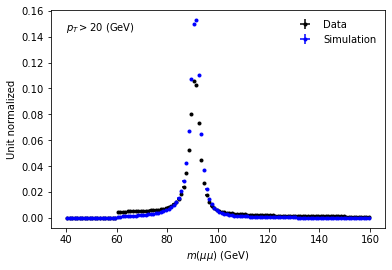

In [14]:
plot(dfs_pt20, 'mass', np.array(range(40,161,1)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text=r'$p_{T} > 20$ (GeV)')

### Single ID efficiency

Grab the efficiency of the `TightID` with `TrackerMuons` as a denominator.
This will be a cut-and-count efficiency.

In [15]:
num, den = 'TightID', 'TrackerMuons'
realized_abseta_pt = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

The returned dataframe has keys for the numerator, denominator, pass/fail, and the binning structure chosen.

In [16]:
realized_abseta_pt['Run2017']

,pass,num,den,absetaBin,ptBin,sumw,sumw2
0,True,TightID,TrackerMuons,2.0,5.0,1014197.0,1014197.0
1,False,TightID,TrackerMuons,3.0,8.0,131.0,131.0
2,False,TightID,TrackerMuons,5.0,2.0,4463.0,4463.0
3,True,TightID,TrackerMuons,4.0,2.0,58370.0,58370.0
4,True,TightID,TrackerMuons,1.0,6.0,871839.0,871839.0
5,True,TightID,TrackerMuons,2.0,2.0,55562.0,55562.0
6,False,TightID,TrackerMuons,2.0,0.0,1618.0,1618.0
7,False,TightID,TrackerMuons,3.0,7.0,4251.0,4251.0
8,False,TightID,TrackerMuons,2.0,4.0,25385.0,25385.0
9,False,TightID,TrackerMuons,4.0,2.0,3982.0,3982.0


Now, let's plot these efficiencies. Four plots are shown for the four `abseta` bins in the 2D binning structure we chose.

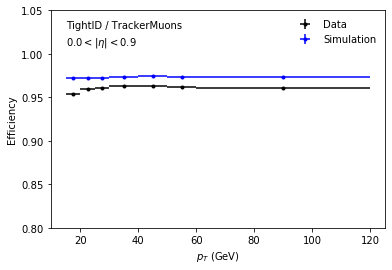

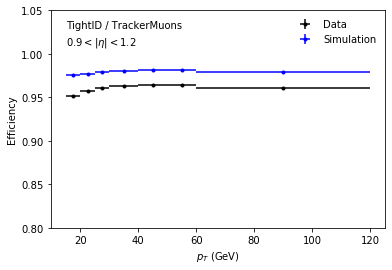

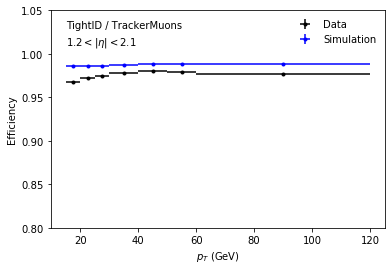

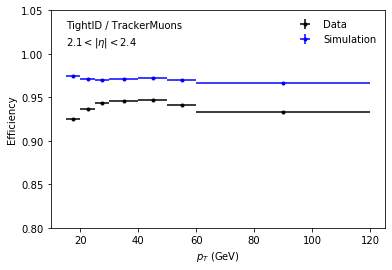

In [17]:
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = binning['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text)

You can see the raw efficiencies here.

In [18]:
df_eff['Run2017']

eff   eff_err
num     den          absetaBin ptBin                    
TightID TrackerMuons 1.0       0.0    0.932092  0.001820
                               1.0    0.953529  0.000860
                               2.0    0.959685  0.000482
                               3.0    0.960836  0.000301
                               4.0    0.962909  0.000122
                               5.0    0.963363  0.000096
                               6.0    0.962202  0.000200
                               7.0    0.960709  0.000324
                               8.0    0.947541  0.002460
                     2.0       0.0    0.889186  0.002598
                               1.0    0.951368  0.001341
                               2.0    0.956811  0.000844
                               3.0    0.960816  0.000537
                               4.0    0.962790  0.000229
                               5.0    0.964609  0.000180
                               6.0    0.963987  0.000376
                               7.0    0.961307  0.000624
                               8.0    0.945396  0.004888
                     3.0       0.0    0.690404  0.001490
                               1.0    0.967888  0.000554
                               2.0    0.972783  0.000362
                               3.0    0.974968  0.000249
                               4.0    0.977760  0.000116
                               5.0    0.979810  0.000096
                               6.0    0.978909  0.000204
                               7.0    0.977353  0.000343
                               8.0    0.967372  0.002804
                     4.0       0.0    0.440676  0.001942
                               1.0    0.925297  0.001380
                               2.0    0.936137  0.000979
                               3.0    0.943491  0.000697
                               4.0    0.945585  0.000363
                               5.0    0.946436  0.000357
                               6.0    0.941514  0.000769
                               7.0    0.932957  0.001396
                               8.0    0.883861  0.012443
                     5.0       0.0    0.166019  0.003714
                               1.0    0.410486  0.007363
                               2.0    0.411214  0.005652
                               3.0    0.407384  0.004364
                               4.0    0.412596  0.002368
                               5.0    0.412937  0.002411
                               6.0    0.407439  0.004762
                               7.0    0.403198  0.008289
                               8.0    0.288462  0.062826

### Demonstration of inprogress fitting

The following demonstrates the local running of the fit.
This will eventually be distributed with Spark.

In [23]:
realized_fit = {subEra: get_params(dfs[subEra], num, den,('abseta','pt'), cutAndCount=False) for subEra in subEras}
realized_fit['Run2017']

,pass,num,den,absetaBin,ptBin,massBin,sumw,sumw2
0,True,TightID,TrackerMuons,3.0,1.0,1.0,3053.0,3053.0
1,False,TightID,TrackerMuons,5.0,5.0,33.0,3810.0,3810.0
2,True,TightID,TrackerMuons,4.0,5.0,22.0,3748.0,3748.0
3,True,TightID,TrackerMuons,4.0,1.0,4.0,653.0,653.0
4,False,TightID,TrackerMuons,1.0,4.0,39.0,866.0,866.0
5,False,TightID,TrackerMuons,3.0,3.0,56.0,23.0,23.0
6,False,TightID,TrackerMuons,4.0,0.0,61.0,1030.0,1030.0
7,True,TightID,TrackerMuons,3.0,4.0,61.0,721.0,721.0
8,False,TightID,TrackerMuons,4.0,2.0,35.0,309.0,309.0
9,True,TightID,TrackerMuons,3.0,7.0,66.0,1191.0,1191.0


In [29]:
wrapper = FitWrapper(crystalball_exponential)
fit_data = wrapper.func()
thisDF = realized_fit['Run2017']
fitparams = thisDF[(thisDF['ptBin']==4) & (thisDF['absetaBin']==1)].groupby(['pass','num','den','absetaBin','ptBin']).apply(fit_data)
fitparams

,,,,,,alpha,n,mean,sigma,Nsig,bkglambda,Nbkg,alpha_error,n_error,mean_error,sigma_error,Nsig_error,bkglambda_error,Nbkg_error
pass,num,den,absetaBin,ptBin,,,,,,,,,,,,,,,
False,TightID,TrackerMuons,1.0,4.0,0,1.032756,2.316773,90.752740,2.212877,23651.706689,0.018835,20755.346687,0.014286,0.072015,0.012535,0.012325,128.573306,0.000807,457.523273
True,TightID,TrackerMuons,1.0,4.0,0,1.009657,2.578473,90.758487,2.234901,612962.232718,0.017953,400113.307949,0.002708,0.015493,0.002477,0.002423,650.101668,0.000180,2127.754583
